##imports



In [0]:
from scipy.io import loadmat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from os import listdir
from os.path import isfile, join
import random
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import cv2
import math
from tqdm import tqdm
import time

## 1. Download the dataset and understand the format (5 Points)

In [0]:
#### download and extract dataset
! wget http://web.archive.org/web/20120508113820/http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
! tar xzf BSR_bsds500.tgz

--2018-12-27 23:35:00--  http://web.archive.org/web/20120508113820/http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving web.archive.org (web.archive.org)... 207.241.224.26
Connecting to web.archive.org (web.archive.org)|207.241.224.26|:80... connected.
HTTP request sent, awaiting response... 

In [0]:
! apt-get install tree
! tree -d /content/BSR

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
/content/BSR
├── bench
│   ├── benchmarks
│   ├── data
│   │   ├── groundTruth
│   │   ├── images
│   │   ├── png
│   │   ├── segs
│   │   ├── test_1
│   │   ├── test_2
│   │   ├── test_3
│   │   ├── test_4
│   │   ├── test_5
│   │   └── ucm2
│   └── source
├── BSDS500
│   └── data
│       ├── groundTruth
│       │   ├── test
│       │   ├── train
│       │   └── val
│       └── images
│           ├── test
│           ├── train
│           └── val
└── documentation

25 directories


**Observation:** The data is in folder:   
BSDS500  
   └── data  
The jpg images is in `images` folder and groundTruth is in the `groundTruth` folder  

#### understanding mat files

In [0]:
mat_img = loadmat('BSR/BSDS500/data/groundTruth/train/100075.mat')
type(mat_img)

dict

In [0]:
mat_img.keys()

dict_keys(['__header__', '__version__', '__globals__', 'groundTruth'])

In [0]:
type(mat_img['groundTruth'])

numpy.ndarray

In [0]:
mat_img['groundTruth'].shape

(1, 6)

In [0]:
print(mat_img["groundTruth"][0].shape)
print(mat_img["groundTruth"][0][0].shape)
print(mat_img["groundTruth"][0][0][0].shape)
print(mat_img["groundTruth"][0][0][0][0].shape)
print(mat_img["groundTruth"][0][0][0][0][0].shape)

(6,)
(1, 1)
(1,)
()
(321, 481)


In [0]:
print(len(mat_img["groundTruth"][0][0][0][0]))

2


**Observation:** each mat image has `k` images for different `k`s.  
in the previous example: k = 6  
we will plot the k images as columns

---
## 2. Visualize the image and the ground truth segmentation (5 points)
Write your own function that reads an image and display an image with its
associated ground truth segmentation(s).

In [0]:
# subpath: is the image name with a prepath to indicate train, val or test
# ex: val/101085 ... etc
def visualize(image_subpath):
  
  # get images
  jpg_img_path = 'BSR/BSDS500/data/images/'+image_subpath + '.jpg'
  jpg_img = mpimg.imread(jpg_img_path)
  mat_img_path = 'BSR/BSDS500/data/groundTruth/'+image_subpath + '.mat'
  mat_img = loadmat(mat_img_path)
  
  # plotting
  fig=plt.figure(figsize=(20, 8))
  columns = mat_img["groundTruth"].shape[1]+1
  rows = len(mat_img["groundTruth"][0][0][0][0])
  
  for r in range(rows): 
    # add jpg image
    fig.add_subplot(rows, columns, r*columns+1,adjustable='datalim')
    plt.imshow(jpg_img)
    # add mat images
    for i in range(r*columns+2, ((r+1)*columns)+1):
      fig.add_subplot(rows, columns, i, adjustable='datalim')
      plt.imshow(mat_img["groundTruth"][0][i-r*columns-2][0][0][r])
  
  plt.suptitle(image_subpath, fontsize=16)
  plt.show()

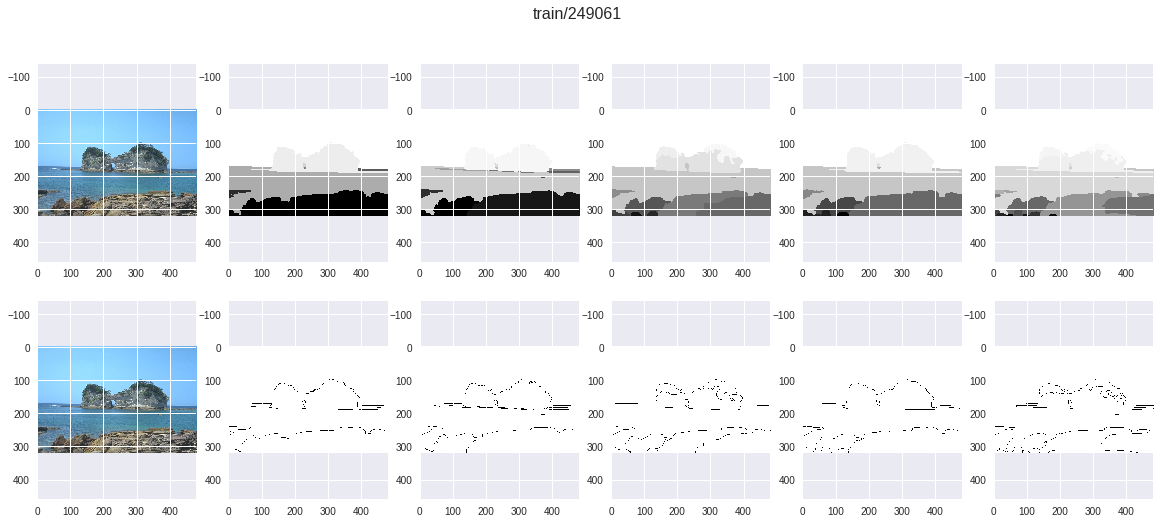

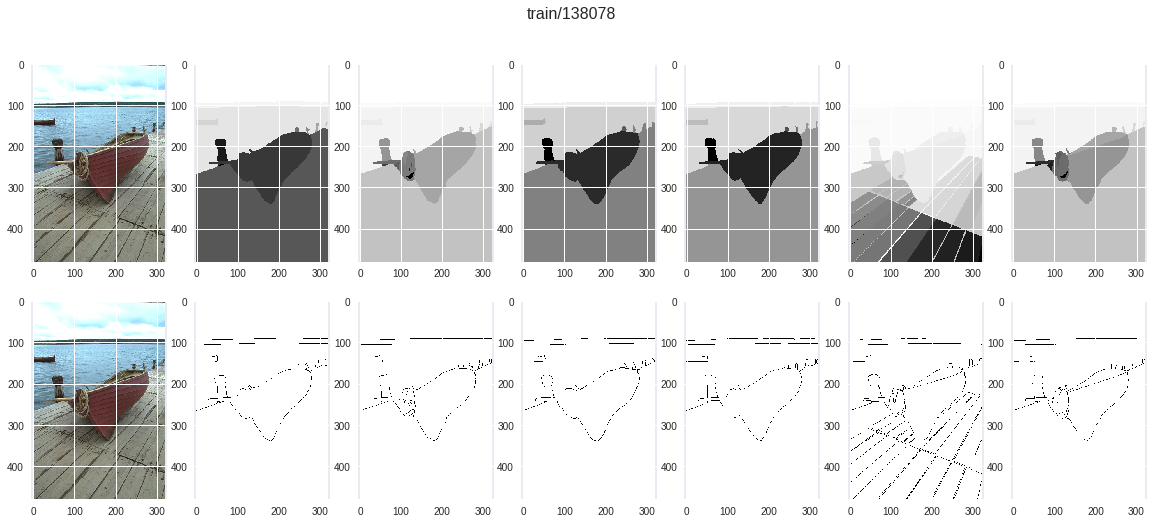

In [0]:
train_images_path = 'BSR/BSDS500/data/images/train/'
files_name = [f for f in listdir(train_images_path) if isfile(join(train_images_path, f))]

# visualization of randomly chosen 2 photos in training set
random_indices = random.sample(range(1, len(files_name)), 2)
for indx in random_indices:
  visualize("train/" + files_name[indx][:-4])
  print();print();

---
## 3. Segmentation using K-means (35 Points)(your implementation)
Every image pixel is a feature vector of 3-dimension {R,G,B}. We will use this feature
representation to do the segmentation.  
**a.** We will change the K of the K-means algorithm between {3,5,7,9,11} clusters.
You will produce different segmentations and save them as colored images. Every
color represents a certain group (cluster) of pixels.  
**b.** We will evaluate the result segmentation using F-measure, Conditional Entropy. For image I with M available ground-truth segmentations. For a clustering of K-clusters you will report your measures M times and the average of the M trials as well. Report average per dataset as well.  
**c.** Display good results and bad results for every configuration in a,b. Discuss

In [0]:
#get data images
train_images_path = 'BSR/BSDS500/data/images/train/'
ytrain_images_path = 'BSR/BSDS500/data/groundTruth/train/'
test_images_path = 'BSR/BSDS500/data/images/test/'
X_train = [train_images_path+f for f in listdir(train_images_path) if isfile(join(train_images_path, f)) and f != 'Thumbs.db']
X_test = [test_images_path+f for f in listdir(test_images_path) if isfile(join(test_images_path, f)) and f != 'Thumbs.db']
y_train = [ytrain_images_path+f for f in listdir(ytrain_images_path) if isfile(join(ytrain_images_path, f)) and f != 'Thumbs.db']

#get 10 random image form test set due to time processing
X_batch_rnd_idx = random.sample(range(1, len(X_test)), 10)
X_batch = [X_test[i] for i in X_batch_rnd_idx]
#get 10 random image form train set due to time processing
Xt_batch_rnd_idx = random.sample(range(1, len(X_train)), 10)
Xt_batch = [X_train[i] for i in X_batch_rnd_idx]
yt_batch = [y_train[i] for i in X_batch_rnd_idx]

In [0]:
#K_means implementaion
def K_mean(image, k):
  K_m = KMeans(n_clusters=k)
  K_m.fit(image)
  centroids = K_m.cluster_centers_
  color_label = K_m.labels_
  return centroids[color_label]
  

In [0]:
#visualoze each orignal image with repect to it's K clusters
def visualize_seg(X, seg_colored_images,k):
  fig=plt.figure(figsize=(10, 10))
  columns = len(k)+1
  rows = 2
  rnd_idx = random.sample(range(1, len(X)), rows)
  r=1
  for idx in rnd_idx:
    # add original image
    orig_img = mpimg.imread(X[idx])
    fig.add_subplot(rows, columns, r,adjustable='datalim')
    plt.imshow(orig_img)
    r+=1
    # add seg_colored images
    for i in k:
      fig.add_subplot(rows, columns, r, adjustable='datalim')
      plt.imshow(seg_colored_images[X[idx]][i])
      r+=1
  
  plt.suptitle('Image segmentation for different Ks', fontsize=16)
  plt.show()

In [0]:
#cluster train data
seg_colored_images = {}
k_cluster = [3,5,7,9,11]
for X in X_train:
  seg_colored_images[X]=[]
  image = mpimg.imread(X)
  w,h,d = image.shape
  image = image.reshape(w*h, d)
  for k in k_cluster:
    seg = K_mean(image,k)
    seg_colored_images[X].append(seg.reshape(w, h, d))

In [0]:
#Evaluation for each cluster 
for idx in range(len(k_cluster)):
  f_measure_toAvg = 0
  cond_ent_toAvg = 0
  
  #for all training data
  for x in X_train:
    predict = convert_to_greyScale(seg_colored_images[x][idx])
    f_measure_avg = 0
    cond_ent_avg = 0
    path_ground = ytrain_images_path + x[len(train_images_path):][:-4] + '.mat'  
    gound_truth = getGroundTruth([path_ground])[0]
    total_ground_len = len(gound_truth)
    
    # for M ground truth
    for idxG in range (len(gound_truth)):
      f_measure_avg += f_measure(predict, gound_truth[idxG])
      cond_ent_avg += cond_entropy(predict, gound_truth[idxG])
    # average for M ground truth, added to total data average 
    f_measure_toAvg += (f_measure_avg / total_ground_len)
    cond_ent_toAvg += (cond_ent_avg / total_ground_len)
  
  # average for all data
  f_measure_toAvg /= len(X_train)
  cond_ent_toAvg /= len(X_train)
  
  print("for K = ", k_cluster[idx], "F_measure = ", f_measure_toAvg)
  print("for K = ", k_cluster[idx], "cond_enntropy = ", cond_ent_toAvg)
    
      
    

for K =  3 F_measure =  0.5336793539281072
for K =  3 cond_enntropy =  1.268663397671817
for K =  5 F_measure =  0.45420339933520565
for K =  5 cond_enntropy =  1.1506500970269247
for K =  7 F_measure =  0.3942915832635836
for K =  7 cond_enntropy =  1.089248929257846
for K =  9 F_measure =  0.34988362986039256
for K =  9 cond_enntropy =  1.0455289060960096
for K =  11 F_measure =  0.31646758962341026
for K =  11 cond_enntropy =  1.0102744404649362


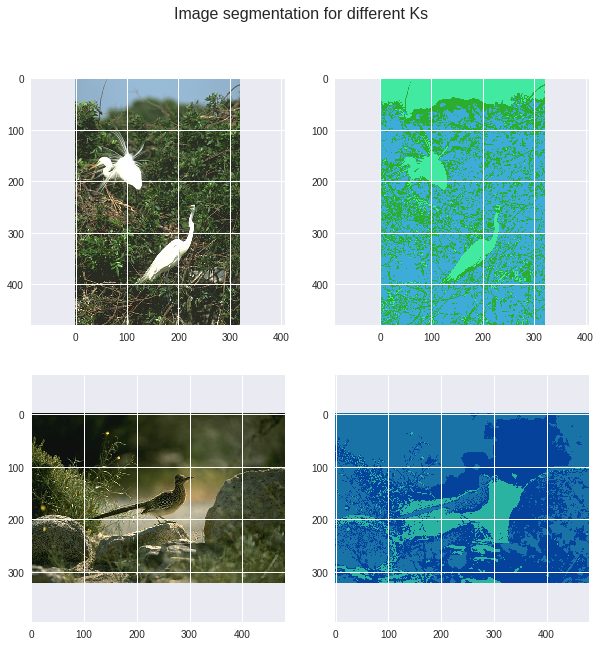

In [0]:
#visualize good results
#k=[3,5,7,9,11]
good_k_indicies = [0]
visualize_seg(X_train, seg_colored_images,good_k_indicies)

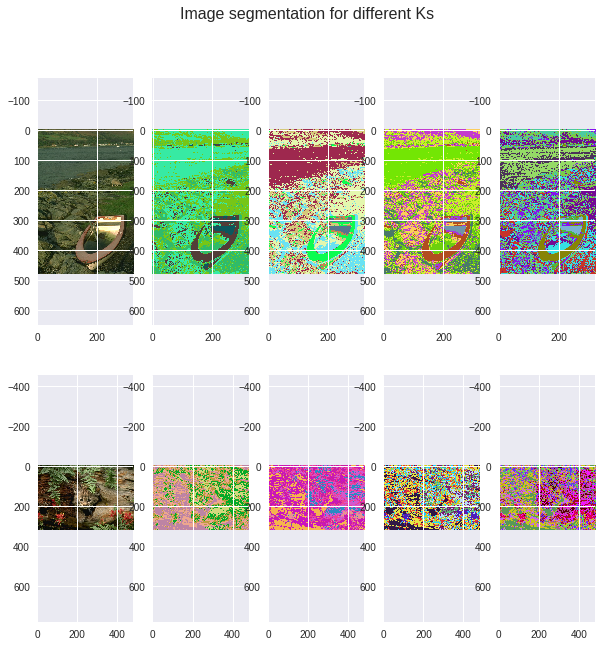

In [0]:
#visualize bad results
#k=[3,5,7,9,11]
bad_k_indicies = [1,2,3,4]
visualize_seg(X_train, seg_colored_images,bad_k_indicies)

## Evaluation

In [0]:
#two images in grey scale
def f_measure(predict, ground_truth):
  F = 0
  predict_clusters, predict_clusters_count = np.unique(predict, return_counts=True)
  for c in predict_clusters:
    predict_idx = np.argwhere(predict == c)
    ground_truth_cluster_val, ground_truth_cluster_count = np.unique(ground_truth[predict_idx[:,0], predict_idx[:,1]], return_counts=True)
    freq_count_inside_cluster =  max(ground_truth_cluster_count)
    max_ground_truth_cluster = ground_truth_cluster_val[np.argmax(ground_truth_cluster_count)]
    total_count_inside_cluster = sum(ground_truth_cluster_count)
    total_count_of_same_cluster = np.count_nonzero(ground_truth == max_ground_truth_cluster)
    
    preci = freq_count_inside_cluster / total_count_inside_cluster
    reci = freq_count_inside_cluster / total_count_of_same_cluster
    fi = (2 * preci * reci) / (preci + reci)
    F+=fi
    
  return F/len(predict_clusters_count)
    
  

In [0]:
#convert numby array image in rgb mode to grey scale
def convert_to_greyScale(rgbImage):
  return np.dot(rgbImage[...,:3], [0.299, 0.587, 0.114])

In [0]:
#two images in grey scale
def cond_entropy(predict, ground_truth):
  cond_entr = 0
  predict_clusters, predict_clusters_count = np.unique(predict, return_counts=True)
  total_pix = sum(predict_clusters_count)
  for c in predict_clusters:
    predict_idx = np.argwhere(predict == c)
    ground_truth_cluster_val, ground_truth_cluster_count = np.unique(ground_truth[predict_idx[:,0], predict_idx[:,1]], return_counts=True)
    total = sum(ground_truth_cluster_count)
    log = np.log(ground_truth_cluster_count / total)
    Tc = sum(np.multiply(ground_truth_cluster_count / total, log) * -1)
    cond_entr += (Tc * total / total_pix)
  return cond_entr

---
## 4. Normalized-Cut Segmentation(40 Points)(your implementation)
**a.** Use RBF kernel with gamma = {1,10} to generate the similarity graph of the pixels. (Be careful of the graph size, you might need to resize the image first if you don’t have 4GB of RAM).  
**b.** Use Similarity graph as the 5-NN graph. Where Sim(xi,xj)=1 iff xj is one of the nearest three points to xi (or vise versa ). xi is the (Ri,Gi,Bi) coordinates for a pixel xi.  
**c.** In every of the above cases set the number of clusters ={3,5,7,9,11}. You will produce different segmentations and save them as colored images. Every color represents a certain group (cluster) of pixels.  
**d.** We will evaluate the result segmentation using F-measure, Conditional Entropy. for image I with M available ground-truth segmentations. For a clustering of K-clusters you will report your measures M times and the average of the M trials as well. Report average per dataset as well.  
**e.** Display good results and bad results for every configuration in a,b. Discuss.

In [0]:
# return ground truth for given paths as list of numpy arrays
def getGroundTruth(paths):
  gt_objects = list()
  for path in paths:
    mat_img = loadmat(path)
    M = len(mat_img["groundTruth"][0])
    for i in range(1): # 1 to ingore borders images
      gt_objects.append(list())
      for j in range(M): # getting ground truth images for k = 5
        gt_objects[i].append(mat_img["groundTruth"][0][j][0][0][i]) 
  return gt_objects

# return images for given paths as list of numpy arrays
def getImages(paths):
  images = list()
  for path in paths:
    jpg_img = mpimg.imread(path)
    images.append(jpg_img)
  return images

In [0]:
# X is an image, y is the ground truth images
def normalizedCut(X, y, gammas, ks):
  w,h,d = X.shape
  fig, axs = plt.subplots(len(gammas), len(ks))
  fmeasure_avg_tot = 0
  for j in range(len(gammas)):
    gamma = gammas[j]
    fmeasure_avg = 0
    entropy_avg = 0
    for i in range(len(ks)):
      start = time.time()
      # the similarity graph using RBF
      model = SpectralClustering(n_clusters=ks[i], affinity='rbf', gamma=gamma, random_state=0, n_jobs=-1).fit(X.reshape(w*h,d))
      similarity_matrix = model.affinity_matrix_
      axs[j,i].imshow(similarity_matrix)
      axs[j,i].set_title("k:"+str(ks[i])+"- gamma:"+str(gamma))
      # Segmentation results
      y_pred = model.labels_
      fmeasure_avg += f_measure(y_pred.reshape(w,h), y[i])
      entropy_avg += cond_entropy(y_pred.reshape(w,h), y[i])
      end = time.time()
      print();print("at k=",ks[i]," fmeasure:", f_measure(y_pred.reshape(w,h), y[i]), "entropy:" , cond_entropy(y_pred.reshape(w,h), y[i]))
      print("time required for k=",ks[i],"and gamma=",gamma,"is:",end-start)
    print();print("at gamma=",gamma," fmeasure avg:", fmeasure_avg/len(ks), "entropy avg:" , entropy_avg)
    fmeasure_avg_tot += fmeasure_avg
  return fmeasure_avg_tot

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



at k= 3  fmeasure: 0.0012331751281615178 entropy: 0.0
time required for k= 3 and gamma= 1 is: 4.102840423583984


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



at k= 5  fmeasure: 0.0012279354462661463 entropy: 0.0
time required for k= 5 and gamma= 1 is: 3.849339485168457


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



at k= 7  fmeasure: 0.0008201625244904492 entropy: 0.0
time required for k= 7 and gamma= 1 is: 2.0813639163970947

at k= 9  fmeasure: 0.0008220472545186001 entropy: 0.0
time required for k= 9 and gamma= 1 is: 0.15182757377624512


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



at k= 11  fmeasure: 0.0008213854644606765 entropy: 0.0
time required for k= 11 and gamma= 1 is: 0.15712451934814453

at gamma= 1  fmeasure avg: 0.0009849411635794781 entropy avg: 0.0

at k= 3  fmeasure: 0.0008221394141728649 entropy: 0.0
time required for k= 3 and gamma= 10 is: 0.05627036094665527

at k= 5  fmeasure: 0.0004912010257660913 entropy: 0.0
time required for k= 5 and gamma= 10 is: 0.047120094299316406


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



at k= 7  fmeasure: 0.00041010345767742334 entropy: 0.0
time required for k= 7 and gamma= 10 is: 0.11158227920532227

at k= 9  fmeasure: 0.0004110348906228958 entropy: 0.0
time required for k= 9 and gamma= 10 is: 0.13061785697937012

at k= 11  fmeasure: 0.00035204145143152014 entropy: 0.0
time required for k= 11 and gamma= 10 is: 0.0851132869720459

at gamma= 10  fmeasure avg: 0.0004973040479341591 entropy avg: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  n_init=n_init)


0.007411226057568186

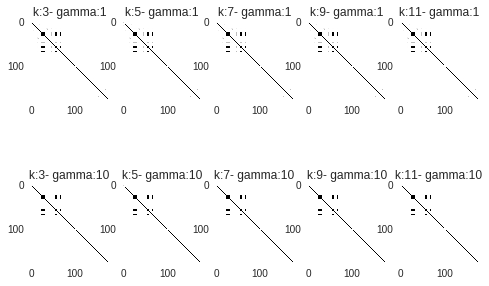

In [0]:
gammas = [1, 10]
ks = [3, 5, 7, 9, 11]
# first image in training data
img = cv2.imread(Xt_batch[0])
# image resizing
res_img = cv2.resize(img, dsize=(math.ceil(img.shape[1]/32), math.ceil(img.shape[0]/32)))
# normalized cut
paths = list()
paths.append(yt_batch[0])
normalizedCut(res_img, getGroundTruth(paths)[0], gammas, ks)

In [0]:
# all training Dataset 
for (X,y) in zip(Xt_batch, yt_batch):
  img = cv2.imread(X)
  # image resizing
  res_img = cv2.resize(img, dsize=(math.ceil(img.shape[1]/16), math.ceil(img.shape[0]/16)))
  # normalized cut
  paths = list()
  paths.append(y)
  normalizedCut(res_img, getGroundTruth(paths)[0], gammas, ks)

---
## 5. Big Picture (15 Points)
**a.** Select a set of five images and display their corresponding ground truth against your segmentation results using K-means at K=5. Comment on the results.  
**b.** Select the same five images and display their corresponding ground truth against your segmentation results using Normalized-cut for the 5-NN graph, at K=5.
Comment on the results.  
**c.** Select the same five images and contrast your segmentation results using Normalized-cut for the 5-NN graph, at K=5 versus using K-means at K=5. Comment on the results.

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarn

nc: [0.0010987704318959233, 0.008438008144814031, 0.01045875853069815, 0.0019981832559184806, 0.015582139959088302]
nc avg: 0.007515172064482978


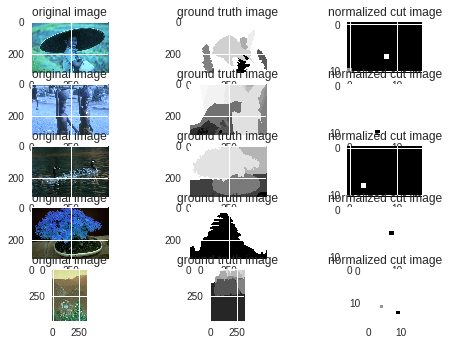

In [0]:
five_images = Xt_batch[0:5]
five_gt = yt_batch[0:5]


# kmeans
f_measures_km = list()
for (X,y) in zip(five_images, five_gt):
  pass


# normalized cut
f_measures_nc = list()
fig, axs = plt.subplots(len(five_images), 3)
i=0
for (X,y) in zip(five_images, five_gt):
  img = cv2.imread(X)
  # image resizing
  res_img = cv2.resize(img, dsize=(math.ceil(img.shape[1]/32), math.ceil(img.shape[0]/32)))
  w,h,d = res_img.shape
  # normalized cut
  paths = list()
  paths.append(y)
  model = SpectralClustering(n_clusters=5, affinity='rbf', gamma=1, random_state=0, n_jobs=-1).fit(res_img.reshape(w*h,d))
  gt = getGroundTruth(paths)[0][0]
  pred = model.labels_
  fmeasure = f_measure(pred.reshape(w,h), gt)
  f_measures_nc.append(fmeasure)
  axs[i,0].imshow(img)
  axs[i,0].set_title("original image")
  axs[i,1].imshow(getGroundTruth(paths)[0][0])
  axs[i,1].set_title("ground truth image")
  axs[i,2].imshow(model.labels_.reshape(w,h))
  axs[i,2].set_title("normalized cut image")
  i+=1
# compare k_means and normalized cut
# print("k_means:", f_measures_km)
print("nc:", f_measures_nc)
# print("k_means avg:", sum(f_measures_km)/len(f_measures_km))
print("nc avg:", sum(f_measures_nc)/len(f_measures_nc))

In [0]:
#K means
seg_colored_images = {}
k_cluster = [5]
for X in five_images:
  seg_colored_images[X]=[]
  image = mpimg.imread(X)
  w,h,d = image.shape
  image = image.reshape(w*h, d)
  for k in k_cluster:
    seg = K_mean(image,k)
    seg_colored_images[X].append(seg.reshape(w, h, d))

In [0]:
  f_measure_toAvg = 0
  cond_ent_toAvg = 0
  
  #for all training data
  for x in five_images:
    predict = convert_to_greyScale(seg_colored_images[x][0])
    f_measure_avg = 0
    cond_ent_avg = 0
    path_ground = ytrain_images_path + x[len(train_images_path):][:-4] + '.mat'  
    gound_truth = getGroundTruth([path_ground])[0]
    total_ground_len = len(gound_truth)
    
    # for M ground truth
    for idxG in range (len(gound_truth)):
      f_measure_avg += f_measure(predict, gound_truth[idxG])
      cond_ent_avg += cond_entropy(predict, gound_truth[idxG])
    # average for M ground truth, added to total data average 
    f_measure_toAvg += (f_measure_avg / total_ground_len)
    cond_ent_toAvg += (cond_ent_avg / total_ground_len)
  
  # average for all data
  f_measure_toAvg /= len(five_images)
  cond_ent_toAvg /= len(five_images)
  
  print("for K = 5  F_measure = ", f_measure_toAvg)
  print("for K = 5  cond_enntropy = ", cond_ent_toAvg)

for K = 5  F_measure =  0.011723599234935605
for K = 5  cond_enntropy =  0.02530128041221524


In [0]:
#visualoze each orignal image with repect to it's K clusters
def visualize_seg_5(X, seg_colored_images,k):
  fig=plt.figure(figsize=(10, 10))
  rows = 5
  columns = 2
  r = 1
  for idx in range(5):
    # add original image
    orig_img = mpimg.imread(X[idx])
    fig.add_subplot(rows, columns, r,adjustable='datalim')
    plt.imshow(orig_img)
    r+=1
    # add seg_colored images
    for i in k:
      fig.add_subplot(rows, columns, r, adjustable='datalim')
      plt.imshow(seg_colored_images[X[idx]][i])
      r+=1
  
  plt.suptitle('Image segmentation for different Ks', fontsize=16)
  plt.show()

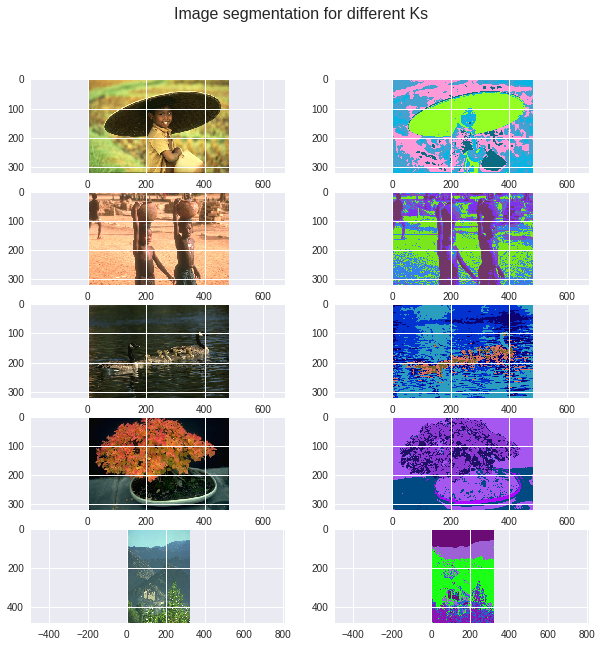

In [0]:
visualize_seg_5(five_images, seg_colored_images, [0])